# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('./Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('./AZDIAS_Feature_Summary.csv', sep=(';'))

In [3]:
pd.options.display.max_columns = 100
pd.options.display.max_rows = 10 # change this to display more/less

In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print('**** azdias shape****')
print(azdias.shape)


print('****azdias.head printout****')
print(azdias.head(100))


**** azdias shape****
(891221, 85)
****azdias.head printout****
    AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0         -1                     2          1            2.0   
1         -1                     1          2            5.0   
2         -1                     3          2            3.0   
3          2                     4          2            2.0   
4         -1                     3          1            5.0   
..       ...                   ...        ...            ...   
95        -1                     1          1            4.0   
96        -1                     2          1            6.0   
97        -1                     2          1            6.0   
98        -1                     3          1            4.0   
99        -1                     2          2            6.0   

    FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                   3              4                 3               5   
1                  

In [5]:
# Taking a look at the summary of azdias. Many columns have missing values, especiall KK_KUNDENTYP
print('****azdias summary****')
print(azdias.describe())


****azdias summary****
            AGER_TYP  ALTERSKATEGORIE_GROB      ANREDE_KZ  CJT_GESAMTTYP  \
count  891221.000000         891221.000000  891221.000000  886367.000000   
mean       -0.358435              2.777398       1.522098       3.632838   
std         1.198724              1.068775       0.499512       1.595021   
min        -1.000000              1.000000       1.000000       1.000000   
25%        -1.000000              2.000000       1.000000       2.000000   
50%        -1.000000              3.000000       2.000000       4.000000   
75%        -1.000000              4.000000       2.000000       5.000000   
max         3.000000              9.000000       2.000000       6.000000   

       FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
count      891221.000000  891221.000000     891221.000000   891221.000000   
mean            3.074528       2.821039          3.401106        3.033328   
std             1.321055       1.464749          1.322134    

In [6]:
azdias['AGER_TYP'].value_counts()

-1    677503
 2     98472
 1     79802
 3     27104
 0      8340
Name: AGER_TYP, dtype: int64

In [7]:
# azdias.loc[1:100, 'ALTERSKATEGORIE_GROB']
azdias['ALTERSKATEGORIE_GROB'].value_counts()

3    358533
4    228510
2    158410
1    142887
9      2881
Name: ALTERSKATEGORIE_GROB, dtype: int64

In [8]:
# Taking a look at the features file. Not much useful info unless I can talk to someone who can explain what the values mean...
print('****features****')
print(feat_info)

****features****
               attribute information_level         type missing_or_unknown
0               AGER_TYP            person  categorical             [-1,0]
1   ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2              ANREDE_KZ            person  categorical             [-1,0]
3          CJT_GESAMTTYP            person  categorical                [0]
4      FINANZ_MINIMALIST            person      ordinal               [-1]
..                   ...               ...          ...                ...
80              PLZ8_HHZ    macrocell_plz8      ordinal               [-1]
81              PLZ8_GBZ    macrocell_plz8      ordinal               [-1]
82                ARBEIT         community      ordinal             [-1,9]
83           ORTSGR_KLS9         community      ordinal             [-1,0]
84              RELAT_AB         community      ordinal             [-1,9]

[85 rows x 4 columns]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [9]:
# Identify missing or unknown data values and convert them to NaNs.
nanValuesList = []
for row in feat_info.itertuples(): # Looping the feat_info to grab the column names and missing or unknown values to be replaced with nan.
    nanValues = row.missing_or_unknown
    # Converting the missing_or_unknown value from string to list. Probably not the best way, but it works...
    nanValues = nanValues.replace('[', '') 
    nanValues = nanValues.replace(']', '')
    nanValuesList = nanValues.split(',')

    # Looping the nanValuesList to replace with nan 
    for i in nanValuesList:
        if i == '' or i == 'X' or i == 'XX':
            azdias[row.attribute].replace(i, np.nan, inplace=True)
        else:
            azdias[row.attribute].replace(int(i), np.nan, inplace=True)


In [10]:
# Printing out the head of the azdias df to make sure the above operation completed successfully
print(azdias.head())


   AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0       NaN                   2.0          1            2.0   
1       NaN                   1.0          2            5.0   
2       NaN                   3.0          2            3.0   
3       2.0                   4.0          2            2.0   
4       NaN                   3.0          1            5.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   
2                  1              4                 1               2   
3                  4              2                 5               2   
4                  4              3                 4               1   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  FINANZTYP  GEBURTSJAHR  \
0                      5                 3          4          NaN   
1                      4                 5

In [11]:
# Now -1, 0, and 9 (missing or unknown values) are no longer shown here as they are converted to nan 
azdias['ALTERSKATEGORIE_GROB'].value_counts()

3.0    358533
4.0    228510
2.0    158410
1.0    142887
Name: ALTERSKATEGORIE_GROB, dtype: int64

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

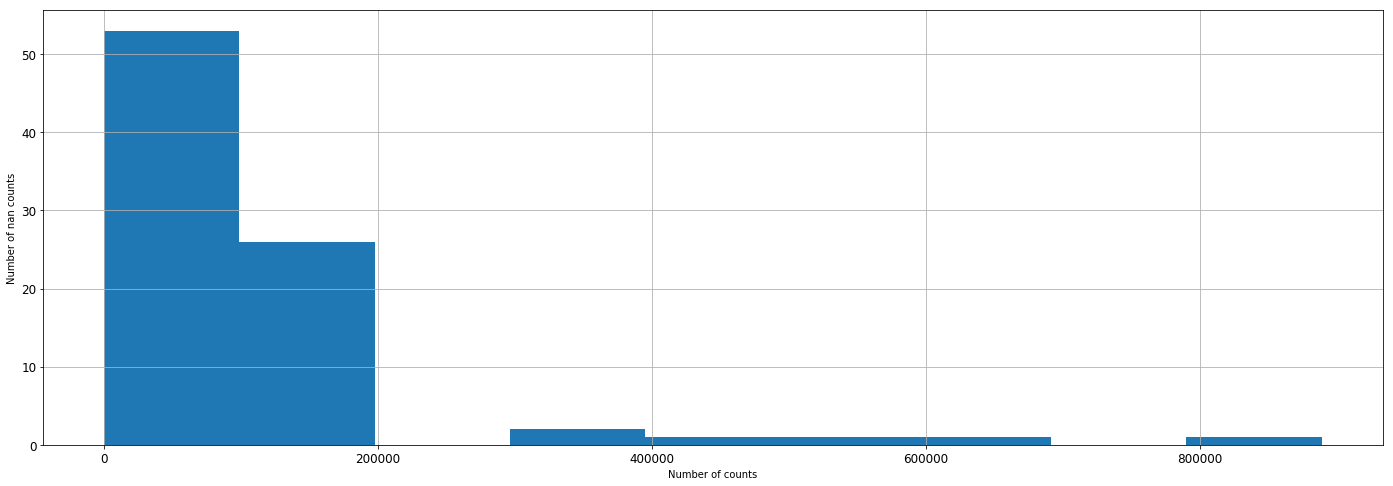

In [12]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
nanCounts = azdias.isnull().sum()
plt.rcParams['figure.figsize'] = [24,8]
nanCounts.hist(bins=9,xlabelsize=12, ylabelsize=12)
plt.ylabel('Number of nan counts')
plt.xlabel('Number of counts')
plt.show()

The figure above shows that majority of columns have no more than 200000 missing values, and a few columns that are missing significantly more observations. Hence, the nan count of greater than 200000 is a reasonable cut-off to determine the outlier columns.

In [13]:
# Investigate patterns in the amount of missing data in each column.
missingCounts = list(azdias.isnull().sum())
featureNames = list(azdias.columns)
for i in range(len(missingCounts)):
    print('{0}: {1}'.format(featureNames[i], missingCounts[i]))

AGER_TYP: 685843
ALTERSKATEGORIE_GROB: 2881
ANREDE_KZ: 0
CJT_GESAMTTYP: 4854
FINANZ_MINIMALIST: 0
FINANZ_SPARER: 0
FINANZ_VORSORGER: 0
FINANZ_ANLEGER: 0
FINANZ_UNAUFFAELLIGER: 0
FINANZ_HAUSBAUER: 0
FINANZTYP: 0
GEBURTSJAHR: 392318
GFK_URLAUBERTYP: 4854
GREEN_AVANTGARDE: 0
HEALTH_TYP: 111196
LP_LEBENSPHASE_FEIN: 97632
LP_LEBENSPHASE_GROB: 94572
LP_FAMILIE_FEIN: 77792
LP_FAMILIE_GROB: 77792
LP_STATUS_FEIN: 4854
LP_STATUS_GROB: 4854
NATIONALITAET_KZ: 108315
PRAEGENDE_JUGENDJAHRE: 108164
RETOURTYP_BK_S: 4854
SEMIO_SOZ: 0
SEMIO_FAM: 0
SEMIO_REL: 0
SEMIO_MAT: 0
SEMIO_VERT: 0
SEMIO_LUST: 0
SEMIO_ERL: 0
SEMIO_KULT: 0
SEMIO_RAT: 0
SEMIO_KRIT: 0
SEMIO_DOM: 0
SEMIO_KAEM: 0
SEMIO_PFLICHT: 0
SEMIO_TRADV: 0
SHOPPER_TYP: 111196
SOHO_KZ: 73499
TITEL_KZ: 889061
VERS_TYP: 111196
ZABEOTYP: 0
ALTER_HH: 310267
ANZ_PERSONEN: 73499
ANZ_TITEL: 73499
HH_EINKOMMEN_SCORE: 18348
KK_KUNDENTYP: 584612
W_KEIT_KIND_HH: 147988
WOHNDAUER_2008: 73499
ANZ_HAUSHALTE_AKTIV: 99611
ANZ_HH_TITEL: 97008
GEBAEUDETYP: 93148
KONS

Some of the missing values are highly correlated. For example, LP_FAMILIE_FEIN and LP_FAMILIE_GROB (both missing 77792), LP_STATUS_FEIN and LP_STATUS_GROB (both missing 4854), SHOPPER_TYP and VERS_TYP (both missing 111196) have the same number of missing values. All of the PLZ8 related features have the same number of missing values (116515). Likewise, none of the SEMIO related features are missing any values.

Based on the above counts, AGER_TYP, GEBURTSJAHR, TITEL_KZ, ALTER_HH, KK_KUNDENTYP, and KBA05_BAUMAX will be discarded. 

In [14]:
azdias.shape

(891221, 85)

In [15]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
deletedFeaturesList = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
azdias.drop(deletedFeaturesList, axis=1, inplace=True)

A note about feature removal:

Some features that end with FEIN and GROB (e.g. LP_LEBENSPHASE_FEIN [Life stage, fine scale] and LP_LEBENSPHASE_GROB [Life stage, rough scale]) seem to be redundant based on the provided description in Data_Dictionary.md file. Assuming that the fine scale always encompasses the rough scale, all of the GROB features are dropped to avoid redundancy.

Additionally three CAMEO features also seem redundant. The CAMEO_INTL_2015 appear to have a well-structured organization, so CAMEO_DEUG_2015 and CAMEO_DEU_2015 will be dropped.

In [16]:
redundantFeaturesList = ['LP_LEBENSPHASE_GROB', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB', 'CAMEO_DEUG_2015',
                         'CAMEO_DEU_2015']
azdias.drop(redundantFeaturesList, axis=1, inplace=True)

In [17]:
azdias.shape

(891221, 74)

#### Discussion 1.1.2: Assess Missing Data in Each Column

The histogram of the nan counts separates poorly-populated columns from the well-populated columns; most of columns have less than 200000 missing data. Thus 200000 is used as a threshold to keep/discard columns. Based on the nan counts, AGER_TYP, GEBURTSJAHR, TITEL_KZ, ALTER_HH, KK_KUNDENTYP, and KBA05_BAUMAX were removed.  

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

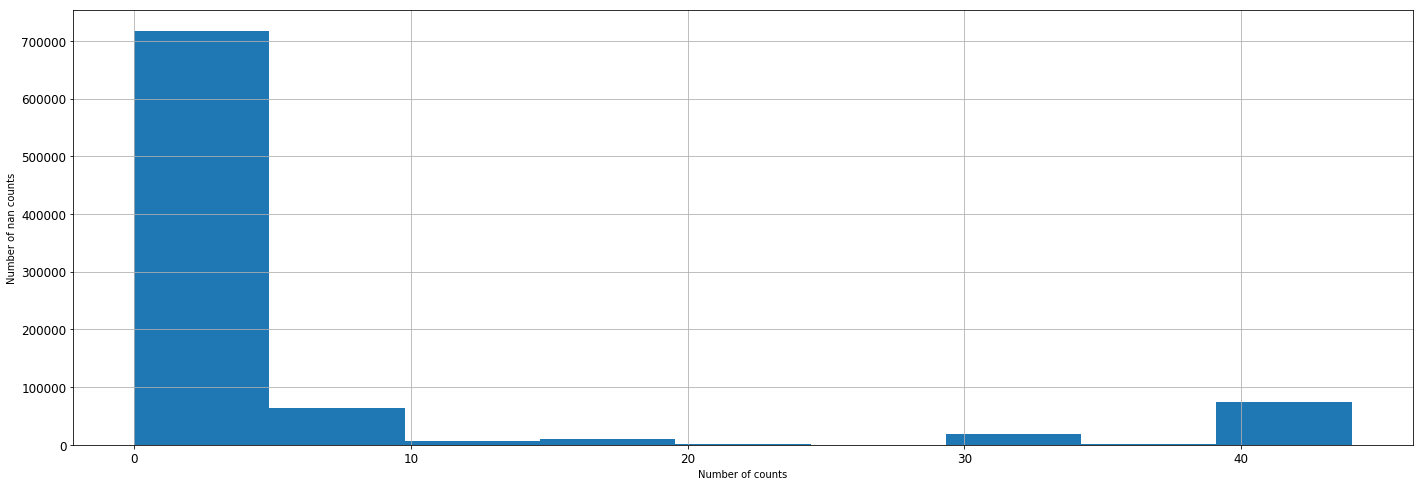

In [18]:
# How much data is missing in each row of the dataset?
nanCounts = azdias.isnull().sum(axis=1)
plt.rcParams['figure.figsize'] = [24,8]
nanCounts.hist(bins=9,xlabelsize=12, ylabelsize=12)
plt.ylabel('Number of nan counts')
plt.xlabel('Number of counts')
plt.show()

In [19]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

azdias['nanCount'] = nanCounts # creating a temp column in azdias for slicing purpose. This column will be removed before training



In [20]:
pd.options.display.max_rows = 10 # making the number of rows to display more manageable.

In [21]:
df_missing = azdias.loc[azdias['nanCount'] > 30].copy() # displaying rows where there are more than 30 nan values.

In [46]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

df_complete = azdias.loc[azdias['nanCount'] < 3].copy() 
#### Be careful here. If the too-small threshold is chosen, I could eliminate an entire class within a feature. 
# Check GEBAEUDETYP ####

In [47]:
df_complete['GEBAEUDETYP'].value_counts()

1.0    384818
3.0    150728
8.0    132292
2.0      1295
4.0       335
6.0       245
5.0         1
Name: GEBAEUDETYP, dtype: int64

In [24]:
df_complete.shape

(669714, 75)

In [48]:
df_complete.drop(['nanCount'], axis=1, inplace=True) # Removing the nanCount column

In [26]:
df_complete.shape

(669714, 74)

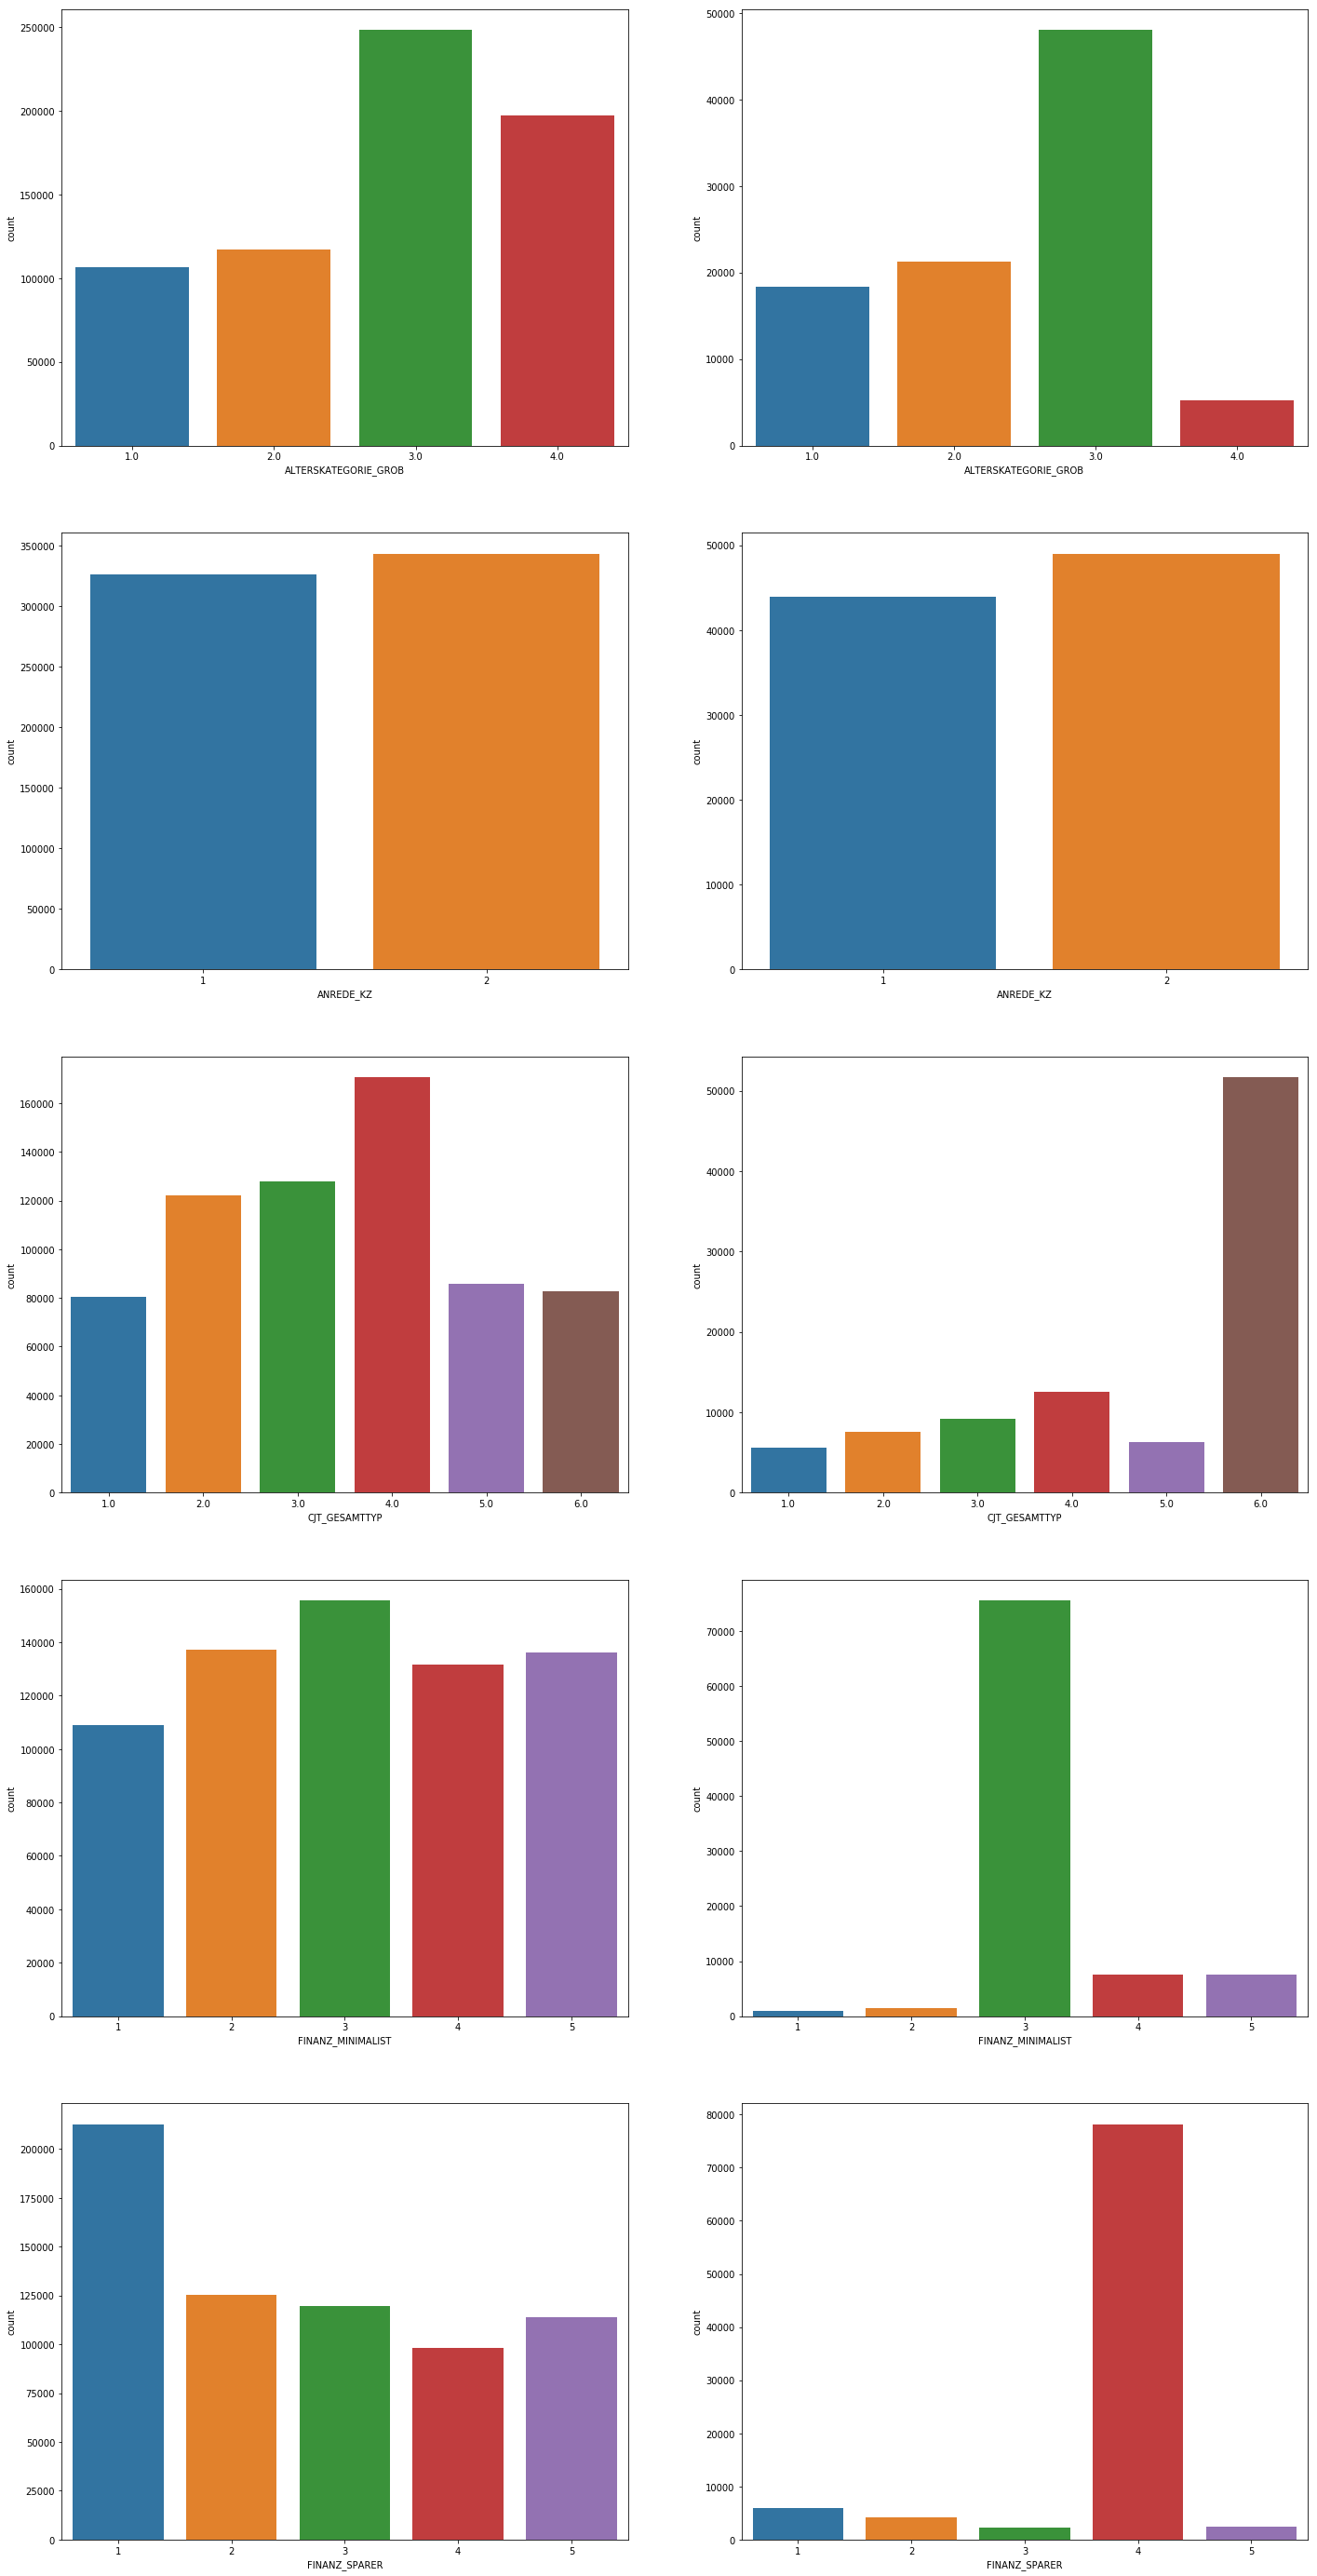

In [27]:
plt.rcParams['figure.figsize'] = [24,50]
numFeatures = feat_info.shape[0]
cellId = 1
# For convenience, disabling the huge graphs display 
# for row in feat_info.itertuples():
    
#     if row.attribute in deletedFeaturesList:
#         continue

#     plt.subplot(79,2,cellId)
#     sns.countplot(data=df_complete, x=row.attribute)
#     cellId += 1
#     plt.subplot(79,2,cellId)

#     if df_missing[row.attribute].isnull().all():
#         plt.text(0.5, 0.5, str('None'))
#     else:
#         sns.countplot(data=df_missing, x=row.attribute)
#     cellId += 1

# Display graphs for only the first five columns (for ease of use). Use the above for loop to view graphs for all features.
for row in feat_info.itertuples():
    
    if row.attribute in deletedFeaturesList:
        continue

    plt.subplot(5,2,cellId)
    sns.countplot(data=df_complete, x=row.attribute)
    cellId += 1
    plt.subplot(5,2,cellId)

    if df_missing[row.attribute].isnull().all():
        plt.text(0.5, 0.5, str('None'))
    else:
        sns.countplot(data=df_missing, x=row.attribute)
    cellId += 1
    if row.Index == 5:
        break
plt.show()

#### Discussion 1.1.3: Assess Missing Data in Each Row

While data distribution of some features between the subset with many missing data (MD) and almost complete data (ACD) have similar character, majority of features have significantly differnet distributions between the MD and ACD subsets. Therefore, it is advisable to impute the missing data rather than to delete observations with missing data.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [28]:
# How many features are there of each data type?
feat_info['type'].value_counts()


ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

There are 21 categorical and 7 mixed features from the original dataset. Since AGER_TYP, TITEL_KZ, KK_KUNDENTYP (all categorical), and KBA05_BAUMAX (mixed) have been dropped, there are 17 and 6 categorical and mixed type data, respectively. 

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [29]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

# Based on visual inspection, the following features were classified into binary, binary-require-re-encoding, and multi-level:

binaryFeatures = ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP']
    
binaryReEncoding = ['OST_WEST_KZ']
    
multiLevel = ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 
              'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP']
    
    

In [30]:
df_complete['OST_WEST_KZ'].value_counts()

W    523554
O    146160
Name: OST_WEST_KZ, dtype: int64

In [49]:
# Re-encode categorical variable(s) to be kept in the analysis.
reEncodeDict = {'OST_WEST_KZ': {'W': 0, 'O': 1}}
df_complete.replace(reEncodeDict, inplace=True)


In [32]:
df_complete['OST_WEST_KZ'].value_counts()

0    523554
1    146160
Name: OST_WEST_KZ, dtype: int64

In [50]:
# One-hot-encoding multi-level categorical features except GEBAEUDETYP. ####
dummiesDict = {}
for f in multiLevel:
    dummiesDict[f] = pd.get_dummies(df_complete[f], prefix=f)

In [51]:
df_complete['GEBAEUDETYP'].value_counts()

1.0    384818
3.0    150728
8.0    132292
2.0      1295
4.0       335
6.0       245
5.0         1
Name: GEBAEUDETYP, dtype: int64

The above printout shows that some categories in GEBAEUDETYP are very sparsely populated (e.g. 4, 5, 6) and category 7 was completely eliminated previously when selecting the "mostly complete rows". This causes different number of dummies columns to be generated when performing a one-hot-encoding with get_dummies method. Therefor, the one-hot-encoding of the GEBAEUDETYP feature will be performed manually.

In [35]:
# Handling GEBAEUDETYP manually.
# a function to make dummies values for GEBAEUDETYP feature

def get_dummies_for_gebaeudetyp(df):
    
    # Create a dictionary with empty values
    gebaeudetypDict = {}
    for i in range(8):
        gebaeudetypDict['GEBAEUDETYP_' + str(i+1)] = []
        
    for row in df.itertuples():
        gebaeudetypValue = row.GEBAEUDETYP
        for i in range(8):
            if i == gebaeudetypValue - 1:
                gebaeudetypDict['GEBAEUDETYP_' + str(i+1)].append(1)
            else:
                gebaeudetypDict['GEBAEUDETYP_' + str(i+1)].append(0)
    return gebaeudetypDict
    

In [52]:
# One-hot-encode GEBAEUDETYP using the get_dummies_for_gebaeudetyp function
gebaeudetypDict = get_dummies_for_gebaeudetyp(df_complete)

#### Discussion 1.2.1: Re-Encode Categorical Features

As most features with missing values seem to have significantly different data distributions compared to observations with few missing data, all missing data will be imputed later. The 'OST_WEST_KZ' feature was a binary in characters ('W'/'O'), and thus converted to integers (0/1). All other binary categorical features were kept unchanged. All multi-level categorical features were one-hot-encoded into dummy features.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [53]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
pd.options.display.max_rows = 10 # change this to display more/less
df_complete['PRAEGENDE_JUGENDJAHRE']

1         14.0
2         15.0
4          8.0
5          3.0
6         10.0
          ... 
891213    11.0
891214    14.0
891215    10.0
891219    14.0
891220     3.0
Name: PRAEGENDE_JUGENDJAHRE, Length: 669714, dtype: float64

In [54]:
# dictionary for PRAEGENDE_JUGENDJAHRE. For the movement, 0 for mainstream, 1 for avantgarde.
pjDict = {
    1: [40, 0],
    2: [40, 1],
    3: [50, 0],
    4: [50, 1],
    5: [60, 0],
    6: [60, 1],
    7: [60, 1],
    8: [70, 0],
    9: [70, 1],
    10: [80, 0],
    11: [80, 1],
    12: [80, 0],
    13: [80, 1],
    14: [90, 0],
    15: [90, 1]
}


In [55]:
pjYear = []
pjMovement = []
for row in df_complete.itertuples():
    categoryId = row.PRAEGENDE_JUGENDJAHRE
    if np.isnan(categoryId):
        pjYear.append(np.nan)
        pjMovement.append(np.nan)
    else:
        pjYear.append(pjDict[categoryId][0])
        pjMovement.append(pjDict[categoryId][1])

In [56]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
df_complete['CAMEO_INTL_2015']

1         51
2         24
4         43
5         54
6         22
          ..
891213    34
891214    23
891215    31
891219    51
891220    43
Name: CAMEO_INTL_2015, Length: 669714, dtype: object

In [57]:
cameoWealth = []
cameoStage = []
for row in df_complete.itertuples():
    cameoId = float(row.CAMEO_INTL_2015) # a hacky way to avoid error; cameoId comes as a string (except nan, which is float), so convert all to float, then convert numbers to string for processing

    if np.isnan(cameoId):
        cameoWealth.append(np.nan)
        cameoStage.append(np.nan)
    else:
        cameoWealth.append(int(str(cameoId)[0]))
        cameoStage.append(int(str(cameoId)[1]))

The WOHNLAGE feature is a mixed data of two features; a first set of a quality of neighborhood (multi-level, 1 to 5) and the second, of rural neighborhood/new building in rural neighborhood. Since the first and the second features are independent of each other (e.g. one can line in a new building in a rural neighborhood in a good neighborohood), but are represetnted by one value, it is impossible to re-construct these two features from the original WOHNLAGE column. Thus WOHNLAGE feature will be eliminated from the further analysis.

#### Discussion 1.2.2: Engineer Mixed-Type Features

Features LP_LEBENSPHASE_GROB, CAMEO_DEU_2015 and CAMEO_DEUG_2015 were dropped (at the pre-processing stage) as they were multiplicates of other features. All other features were kept.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [58]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

# Combining clearned/re-engineered features to the main dataframe
for f in multiLevel:
    df_complete = pd.concat([df_complete, dummiesDict[f]], axis=1)
    
for n in list(gebaeudetypDict.keys()):
    df_complete[n] = gebaeudetypDict[n]

df_complete['PRAEGENDE_JUGENDJAHRE_year'] = pjYear
df_complete['PRAEGENDE_JUGENDJAHRE_movement'] = pjMovement
df_complete['CAMEO_INTL_2015_wealth'] = cameoWealth
df_complete['CAMEO_INTL_2015_stage'] = cameoStage

In [59]:
df_complete.shape # Check the df to make sure the join process worked

(669714, 144)

In [60]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

df_complete.drop(multiLevel, axis=1, inplace=True)
df_complete.drop(['GEBAEUDETYP'], axis=1, inplace=True)
df_complete.drop(['WOHNLAGE'], axis=1, inplace=True)
df_complete.drop(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'], axis=1, inplace=True)

In [61]:
df_complete # Check the df_complete again

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,...,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_STATUS_FEIN_1.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,GEBAEUDETYP_1,GEBAEUDETYP_2,GEBAEUDETYP_3,GEBAEUDETYP_4,GEBAEUDETYP_5,GEBAEUDETYP_6,GEBAEUDETYP_7,GEBAEUDETYP_8,PRAEGENDE_JUGENDJAHRE_year,PRAEGENDE_JUGENDJAHRE_movement,CAMEO_INTL_2015_wealth,CAMEO_INTL_2015_stage
1,1.0,2,1,5,2,5,4,5,0,3.0,21.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,1.0,2.0,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1992.0,0,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,...,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,90.0,0.0,5.0,1.0
2,3.0,2,1,4,1,2,3,5,1,3.0,3.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,0.0,1.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,5.0,1992.0,0,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,...,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,90.0,1.0,2.0,4.0
4,3.0,1,4,3,4,1,3,2,0,3.0,32.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,0.0,2.0,4.0,0.0,5.0,2.0,9.0,3.0,0.0,4.0,1992.0,0,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,70.0,0.0,4.0,3.0
5,1.0,2,3,1,5,2,2,5,0,3.0,8.0,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0.0,2.0,1.0,0.0,5.0,6.0,9.0,5.0,0.0,5.0,1992.0,0,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,50.0,0.0,5.0,4.0
6,2.0,2,1,5,1,5,4,3,0,2.0,2.0,4.0,2,5,5,7,2,6,5,5,7,7,4,7,7,7,0.0,1.0,1.0,0.0,6.0,3.0,9.0,4.0,0.0,5.0,1992.0,0,3.0,2.0,0.0,0.0,3.0,6.0,4.0,3.0,5.0,3.0,5.0,2.0,...,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,80.0,0.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891213,4.0,2,3,3,3,5,3,2,1,1.0,36.0,2.0,2,2,4,5,3,5,7,2,3,4,5,6,2,3,0.0,1.0,9.0,0.0,5.0,1.0,9.0,4.0,0.0,4.0,1992.0,0,2.0,1.0,0.0,0.0,5.0,2.0,5.0,5.0,3.0,3.0,4.0,5.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,80.0,1.0,3.0,4.0
891214,1.0,2,1,5,2,3,3,4,0,3.0,2.0,4.0,5,4,4,3,1,2,4,2,6,4,7,6,5,6,0.0,2.0,1.0,0.0,5.0,4.0,9.0,6.0,0.0,2.0,1992.0,0,1.0,2.0,0.0,0.0,5.0,6.0,6.0,2.0,4.0,1.0,3.0,2.0,...,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,90.0,0.0,2.0,3.0
891215,2.0,2,1,5,2,4,5,4,0,2.0,2.0,1.0,2,5,5,7,2,6,5,5,7,6,7,7,6,7,0.0,1.0,1.0,0.0,6.0,3.0,9.0,8.0,0.0,2.0,1992.0,

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [95]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    for row in feat_info.itertuples(): # Looping the feat_info to grab the column names and missing or unknown values to be replaced with nan.
        nanValues = row.missing_or_unknown
        # Converting the missing_or_unknown value from string to list. Probably not the best way, but it works...
        nanValues = nanValues.replace('[', '') 
        nanValues = nanValues.replace(']', '')
        nanValuesList = nanValues.split(',')

        # Looping the nanValuesList to replace with nan 
        for i in nanValuesList:
            if i == '' or i == 'X' or i == 'XX':
                df[row.attribute].replace(i, np.nan, inplace=True)
            else:
                df[row.attribute].replace(int(i), np.nan, inplace=True)
    
    # remove selected columns
    deletedFeaturesList = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 
                           'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB', 'CAMEO_DEUG_2015',
                           'CAMEO_DEU_2015']
    df.drop(deletedFeaturesList, axis=1, inplace=True)
    # remove rows with missing values
    df['nanCount'] = df.isnull().sum(axis=1)
    df_complete = df.loc[df['nanCount'] < 3].copy() # Do I want to remove prediction observations? TBD. 
    df_complete.drop(['nanCount'], axis=1, inplace=True) # Removing the nanCount column
    # select, re-encode, and engineer column values.
    
    # Perform one-hot-encoding for multi-level categorical features
    multiLevel = ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 
                  'LP_STATUS_FEIN','NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP']
    dummiesDict = {}
    for f in multiLevel:
        dummiesDict[f] = pd.get_dummies(df_complete[f], prefix=f)
        
    # One-hot-encode GEBAEUDETYP using the get_dummies_for_gebaeudetyp function
    gebaeudetypDict = get_dummies_for_gebaeudetyp(df_complete)

    # Re-encode OST_WEST_KZ from string to int 
    reEncodeDict = {'OST_WEST_KZ': {'W': 0, 'O': 1}}
    df_complete.replace(reEncodeDict, inplace=True)

    # Re-encode PRAEGENDE_JUGENDJAHRE feature into year and movement columns
    pjDict = {
        1: [40, 0],
        2: [40, 1],
        3: [50, 0],
        4: [50, 1],
        5: [60, 0],
        6: [60, 1],
        7: [60, 1],
        8: [70, 0],
        9: [70, 1],
        10: [80, 0],
        11: [80, 1],
        12: [80, 0],
        13: [80, 1],
        14: [90, 0],
        15: [90, 1]
    }

    pjYear = []
    pjMovement = []
    for row in df_complete.itertuples():
        categoryId = row.PRAEGENDE_JUGENDJAHRE

        if np.isnan(categoryId):
            pjYear.append(np.nan)
            pjMovement.append(np.nan)
        else:
            pjYear.append(pjDict[categoryId][0])
            pjMovement.append(pjDict[categoryId][1])

    # Re-encode CAMEO_INTL_2015 into Wealth and Stage columns
    cameoWealth = []
    cameoStage = []
    for row in df_complete.itertuples():
        cameoId = float(row.CAMEO_INTL_2015) # a hacky way to avoid error; cameoId comes as a string (except nan, which is float), so convert all to float, then convert numbers to string for processing

        if np.isnan(cameoId):
            cameoWealth.append(np.nan)
            cameoStage.append(np.nan)
        else:
            cameoWealth.append(int(str(cameoId)[0]))
            cameoStage.append(int(str(cameoId)[1]))

    # Adding encoded features back to the dataframe
    for f in multiLevel:
        df_complete = pd.concat([df_complete, dummiesDict[f]], axis=1)
    
    # Adding manually encoded GEBAEUDETYP dummies to the dataframe
    for n in list(gebaeudetypDict.keys()):
        df_complete[n] = gebaeudetypDict[n] 

    df_complete['PRAEGENDE_JUGENDJAHRE_year'] = pjYear
    df_complete['PRAEGENDE_JUGENDJAHRE_movement'] = pjMovement
    df_complete['CAMEO_INTL_2015_wealth'] = cameoWealth
    df_complete['CAMEO_INTL_2015_stage'] = cameoStage

    # remove the source columns where one-hot-encoding was performed
    df_complete.drop(multiLevel, axis=1, inplace=True)
    df_complete.drop(['GEBAEUDETYP'], axis=1, inplace=True)
    df_complete.drop(['WOHNLAGE'], axis=1, inplace=True)
    df_complete.drop(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'], axis=1, inplace=True)
    
    # Return the cleaned dataframe.
    return df_complete
    

In [63]:
# Testing the clean_data function
test_df = pd.read_csv('./Udacity_AZDIAS_Subset.csv', sep=';')

In [64]:
test_result = clean_data(test_df)

In [65]:
# Perform a comparison between the two dataframes that should be identical
df_complete.equals(test_result) # Pass

False

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [66]:
df_complete[df_complete.isnull().sum(axis=1) == True]

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,...,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_STATUS_FEIN_1.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,GEBAEUDETYP_1,GEBAEUDETYP_2,GEBAEUDETYP_3,GEBAEUDETYP_4,GEBAEUDETYP_5,GEBAEUDETYP_6,GEBAEUDETYP_7,GEBAEUDETYP_8,PRAEGENDE_JUGENDJAHRE_year,PRAEGENDE_JUGENDJAHRE_movement,CAMEO_INTL_2015_wealth,CAMEO_INTL_2015_stage
195,2.0,1,4,4,1,3,4,1,0,3.0,10.0,1.0,7,7,6,3,6,3,3,7,4,5,2,4,6,5,0.0,2.0,1.0,0.0,5.0,5.0,9.0,NaN,0.0,2.0,1992.0,0,3.0,2.0,0.0,0.0,4.0,2.0,6.0,4.0,5.0,3.0,4.0,2.0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,80.0,0.0,5.0,1.0
315,1.0,2,1,5,3,5,5,4,0,3.0,3.0,1.0,5,4,4,3,2,2,2,5,7,6,6,4,7,6,0.0,2.0,1.0,0.0,4.0,NaN,9.0,2.0,0.0,1.0,1992.0,0,3.0,1.0,0.0,0.0,5.0,5.0,1.0,7.0,3.0,4.0,5.0,5.0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,90.0,0.0,2.0,2.0
332,2.0,1,2,4,1,3,3,4,0,3.0,1.0,4.0,7,7,6,7,7,1,3,7,4,2,4,4,6,5,0.0,1.0,0.0,0.0,6.0,NaN,4.0,17.0,1.0,2.0,1992.0,1,0.0,0.0,0.0,2.0,1.0,1.0,6.0,2.0,4.0,4.0,1.0,3.0,...,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,90.0,0.0,5.0,1.0
432,4.0,2,5,1,4,1,1,4,1,2.0,13.0,5.0,5,1,1,3,2,7,7,2,3,6,5,6,1,1,0.0,1.0,1.0,0.0,2.0,6.0,9.0,NaN,0.0,2.0,1992.0,1,4.0,0.0,0.0,0.0,4.0,1.0,6.0,3.0,4.0,3.0,4.0,1.0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,60.0,1.0,4.0,1.0
459,3.0,1,4,2,4,2,3,2,0,3.0,7.0,3.0,6,6,4,6,5,6,4,6,5,5,5,3,3,4,0.0,2.0,0.0,0.0,6.0,NaN,9.0,12.0,0.0,1.0,1992.0,0,0.0,0.0,2.0,1.0,1.0,5.0,4.0,8.0,3.0,2.0,2.0,2.0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,70.0,0.0,4.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
890772,2.0,1,3,4,3,5,5,2,1,3.0,3.0,1.0,7,7,6,7,6,6,2,7,4,2,2,4,6,5,0.0,1.0,1.0,0.0,2.0,6.0,9.0,NaN,0.0,5.0,1996.0,0,2.0,2.0,0.0,0.0,4.0,6.0,5.0,5.0,5.0,3.0,5.0,3.0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,90.0,1.0,4.0,1.0
890815,4.0,1,4,1,5,1,1,4,0,1.0,6.0,3.0,6,6,5,4,7,5,3,4,1,3,1,2,1,1,0.0,1.0,0.0,0.0,5.0,NaN,9.0,7.0,0.0,2.0,1992.0,0,1.0,0.0,2.0,0.0,2.0,6.0,2.0,5.0,4.0,2.0,2.0,0.0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,60.0,0.0,4.0,3.0
890832,1.0,2,1,5,3,5,4,5,0,1.0,1.0,2.0,1,4,7,3,2,2,2,5,7,7,6,6,7,6,0.0,2.0,0.0,0.0,6.0,NaN,8.0,32.0,0.0,3

In [67]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

from sklearn.preprocessing import Imputer
imputer = Imputer(missing_values=np.nan, strategy='median')
imputedData = imputer.fit_transform(df_complete)
df_imputed = pd.DataFrame(imputedData, index=df_complete.index, columns=df_complete.columns)

In [68]:
df_imputed[df_imputed.isnull().sum(axis=1) == True] # Imputation successful

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,...,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_STATUS_FEIN_1.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,GEBAEUDETYP_1,GEBAEUDETYP_2,GEBAEUDETYP_3,GEBAEUDETYP_4,GEBAEUDETYP_5,GEBAEUDETYP_6,GEBAEUDETYP_7,GEBAEUDETYP_8,PRAEGENDE_JUGENDJAHRE_year,PRAEGENDE_JUGENDJAHRE_movement,CAMEO_INTL_2015_wealth,CAMEO_INTL_2015_stage


In [69]:
# Apply feature scaling to the general population demographics data.
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
rescaledData = scaler.fit_transform(df_imputed.as_matrix())

In [70]:
df_complete.shape

(669714, 132)

In [71]:
df_rescaled = pd.DataFrame(rescaledData, index=df_complete.index, columns=df_complete.columns)

In [72]:
df_rescaled.shape

(669714, 132)

### Discussion 2.1: Apply Feature Scaling

The cleaned dataframe (df_complete) was scaled using MinMaxScaler in sklearn between the range of zero and one. Imputation was performed using the median value of the columns.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [73]:
from sklearn.decomposition import PCA

In [74]:
# Apply PCA to the data.

# Scanning PCA to find the ideal number of components
varianceRatioSums = []
componentNumbers = []
for i in range(10, 120, 10):
    print('performing {0} components...'.format(i))
    pca = PCA(n_components=i)
    pca.fit(df_rescaled)
    varianceRatioSums.append(pca.explained_variance_ratio_.sum())
    componentNumbers.append(i)

performing 10 components...
performing 20 components...
performing 30 components...
performing 40 components...
performing 50 components...
performing 60 components...
performing 70 components...
performing 80 components...
performing 90 components...
performing 100 components...
performing 110 components...


In [75]:
print('# Comp: Sum of Variance Ratio')
for i in range(len(componentNumbers)):
    print('{0}: {1}'.format(str(componentNumbers[i]), str(varianceRatioSums[i])))


# Comp: Sum of Variance Ratio
10: 0.484127559053
20: 0.633194204557
30: 0.737987716277
40: 0.817213761836
50: 0.875923472511
60: 0.915807525259
70: 0.94487877533
80: 0.966213769671
90: 0.981255742873
100: 0.991760517651
110: 0.998755988482


Scan of PCA with various components show that 80 components accounts for approx. 96% of the variance. Hence 80 components were selected for the dimentionality reduction.

In [76]:
num_components=80
pca = PCA(n_components=num_components)
pca.fit(df_rescaled)

PCA(copy=True, iterated_power='auto', n_components=80, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [77]:
# Investigate the variance accounted for by each principal component.

pca.explained_variance_ratio_

array([ 0.12082099,  0.09903135,  0.066356  ,  0.04437939,  0.03313074,
        0.02748843,  0.02609329,  0.0236516 ,  0.02254958,  0.02063398,
        0.0185189 ,  0.01769281,  0.01704281,  0.01572141,  0.01481421,
        0.01431324,  0.01361846,  0.01307029,  0.01277663,  0.01227917,
        0.01204109,  0.01176672,  0.01124608,  0.01078476,  0.01054963,
        0.01025287,  0.00980961,  0.00966883,  0.00935902,  0.00911492,
        0.00869963,  0.00861952,  0.00849875,  0.00827374,  0.0079574 ,
        0.00793676,  0.00746445,  0.00742285,  0.00719192,  0.00707215,
        0.0069394 ,  0.00662258,  0.00643763,  0.00610386,  0.00597961,
        0.00567924,  0.00540337,  0.00531188,  0.00502883,  0.00492759,
        0.00478019,  0.00456619,  0.00418571,  0.00408139,  0.00402344,
        0.00393455,  0.00377681,  0.0037416 ,  0.00348788,  0.00340443,
        0.00330168,  0.00321554,  0.00319219,  0.00307171,  0.00295508,
        0.00279893,  0.00273752,  0.00258413,  0.00253873,  0.00

Text(0.5,1,'Explained Variance Per Principal Component')

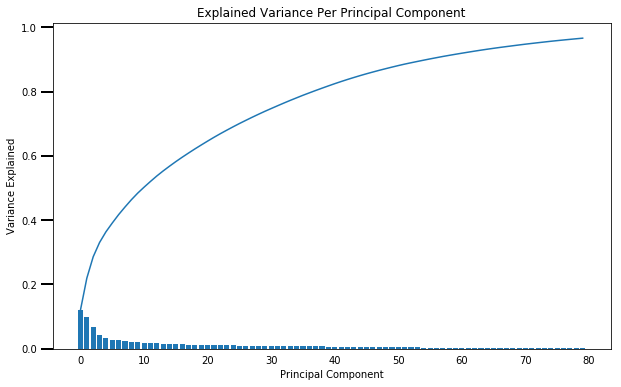

In [78]:
ind = np.arange(num_components)
vals = pca.explained_variance_ratio_

plt.figure(figsize=(10, 6))
ax = plt.subplot(111)
cumvals = np.cumsum(vals)
ax.bar(ind, vals)
ax.plot(ind, cumvals)

ax.xaxis.set_tick_params(width=0)
ax.yaxis.set_tick_params(width=2, length=12)

ax.set_xlabel("Principal Component")
ax.set_ylabel("Variance Explained")
plt.title('Explained Variance Per Principal Component')

In [79]:
# Re-apply PCA to the data while selecting for number of components to retain.

transformedData = pca.transform(df_rescaled)

In [80]:
df_reduced_scaled = pd.DataFrame(transformedData, index=df_rescaled.index)

In [81]:
df_reduced_scaled

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79
1,1.731346,-0.716709,-1.046544,0.355623,-0.007466,0.050614,1.019232,-0.481468,-0.179707,-0.810670,-0.366737,0.421824,0.426153,1.016927,-0.273785,0.307592,-0.012629,-0.464392,-0.835182,-0.065308,-0.383322,0.358953,-0.535997,-0.469856,-0.478946,-0.839172,-0.723961,0.299350,-0.278580,-0.476985,0.027868,-0.333741,-0.260030,0.270361,-0.619194,-0.069822,0.474012,0.219815,0.193153,-0.116754,0.004067,-0.320056,0.037656,0.198544,-0.218295,0.065337,0.143860,-0.004731,-0.187737,0.089095,-0.125191,0.190720,-0.148205,-0.096108,-0.012277,-0.037449,-0.002230,0.099359,-0.161144,0.060750,-0.146541,0.369845,-0.316292,0.082595,-0.118595,-0.045951,-0.029257,0.078831,0.133110,0.091214,-0.081446,0.270121,0.068460,0.108051,0.244486,-0.030074,-0.017830,0.087132,-0.150761,-0.235006
2,0.093118,-0.379410,-1.159175,0.991218,-1.058609,-0.247784,-0.538680,0.259571,-0.653016,0.260666,-0.300145,0.016344,0.064589,0.409670,0.746047,-0.442253,-0.777390,0.136978,0.438481,0.318009,-0.068097,-0.197826,0.174949,-0.655386,-0.409724,-0.102097,-0.241181,-0.094476,0.535020,-0.209229,-0.431448,-0.018820,-0.521143,0.345577,0.349289,-0.346619,0.764794,-0.188082,-0.292458,0.092375,0.311322,0.032987,0.230886,0.085096,0.597748,0.112080,0.215365,-0.164842,-0.683900,0.282931,-0.125903,0.040922,0.032099,-0.279362,0.009485,-0.103635,-0.053712,0.384149,0.178523,-0.257915,-0.189788,0.031001,0.060602,0.034122,-0.130408,0.073520,0.081513,-0.036208,0.145522,-0.165671,0.150174,-0.192171,0.062427,0.151531,-0.057838,0.093951,-0.061324,0.119364,-0.079660,0.128112
4,-0.032043,-0.142371,0.941212,0.316565,1.057133,-1.105740,-0.515118,-0.951061,-0.291181,0.111153,0.220725,0.000705,0.118368,-0.865484,0.461789,-0.149623,-0.765256,0.428073,-0.433660,-1.024900,0.042173,-0.238023,0.341934,-0.247637,-0.259635,-0.111595,-0.096992,0.562564,-0.025386,-0.100865,-0.144117,-0.370186,-0.440243,-0.187903,0.226352,-0.301480,-0.213214,0.189624,-0.156528,0.382829,0.590722,-0.321411,-0.337679,0.184030,-0.149695,0.011561,0.346512,0.014747,-0.300357,-0.000413,0.096086,-0.210163,0.160058,-0.026618,0.002353,0.128486,-0.248114,0.110553,0.288572,-0.001753,-0.228441,-0.123980,-0.274087,0.040074,0.214046,-0.106114,-0.300965,0.220510,-0.066641,0.064467,0.023316,-0.244157,-0.258119,0.027933,0.148069,0.092286,-0.132582,-0.262099,0.165421,0.058850
5,-0.137033,-0.400153,-0.475547,-0.947916,-0.920375,-0.567792,-0.081332,-0.390228,-0.287195,-0.450701,-0.421126,-0.312892,0.024497,-0.775242,-0.119860,1.188474,0.671420,-0.007880,0.113263,0.046996,-0.614959,-0.078707,0.638178,0.710626,0.170595,0.023182,-0.936260,0.063223,0.266290,0.525446,0.315445,-0.144049,-0.129633,-0.050881,-0.459565,0.078245,-0.365864,0.255054,-0.411928,-0.183922,-0.295958,-0.609021,0.054053,-0.279297,-0.162879,0.127958,-0.145399,-0.346195,-0.001811,0.887036,-0.241948,-0.249606,-0.265855,-0.028239,0.105249,-0.207572,0.253455,-0.177655,0.089894,0.230259,-0.201838,-0.187945,0.023784,0.256139,0.300345,-0.162222,0.052361,0.003047,0.004549,0.053893,0.006937,0.003458,-0.093599,0.151152,0.154578,0.203471,-0.060093,0.140104,0.090729,0.188183
6,0.776465,-1.222324,-1.106672,-0.438124,-0.907986,-0.141357,-0.129848,0.447239,0.817341,0.433879,0.094410,-0.346147,0.257820,-0.581731,0.319542,-0.228338,0.142029,-0.158636,-0.071225,-0.591179,0.094284,-0.023954,-0.087389,0.133565,0.385031,-0.162745,0.213117,0.791487,0.199409,-0.112133,0.603841,-0.314558,-0.637183,-0.024517,-0.264354,0.054648,-0.020579,0.610207,0.322370,0.160672,-0.075033,0.204833,0.278656,0.625997,-0.192937,-0.169546,-0.009805,-0.424415,0.493862,-0.329406,0.090454,0.545266,0.102555,-0.475748,0.157574,-0.137787,0.256736,-0.045532,0.098897,-0.080063,-0.101194,-0.370897,-0.075179,0.131609,-0.114213,0.071672,-0.019439,0.073630,-0.131758,-0.165531,0.233837,-0.272383,-0.099745,-0.207543,0

#### Discussion 2.2: Perform Dimensionality Reduction

After the preprocessing, the data had 144 features, which was reduced to 80. This reduction retained 96.3% of the variance while reducing the dimentionality to nearly half of the original data.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [82]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

# A method to print original features with their corresponding weights used in the dimentionality reduction transformation
def print_component_weights(pca, n):
    component = pca.components_[n]
    df_component_weights = pd.DataFrame(component)
    df_component_weights = pd.DataFrame(component, columns=['Weight'])
    df_component_weights['Feature Name'] = df_rescaled.columns

    print(df_component_weights.sort_values(by=['Weight'], ascending=False))

In [83]:
# Print out of the first component weights
print_component_weights(pca, 0)


       Weight            Feature Name
3    0.201533           FINANZ_SPARER
68   0.195095             FINANZTYP_1
130  0.171691  CAMEO_INTL_2015_wealth
55   0.171056              PLZ8_ANTG4
56   0.169405             PLZ8_BAUMAX
..        ...                     ...
4   -0.158145        FINANZ_VORSORGER
42  -0.161519               KBA05_GBZ
0   -0.163414    ALTERSKATEGORIE_GROB
38  -0.185147             KBA05_ANTG1
2   -0.223000       FINANZ_MINIMALIST

[132 rows x 2 columns]


In [84]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

print_component_weights(pca, 1)

       Weight                Feature Name
116  0.280308                  ZABEOTYP_3
97   0.194835          LP_STATUS_FEIN_1.0
0    0.190513        ALTERSKATEGORIE_GROB
4    0.173667            FINANZ_VORSORGER
11   0.156645              RETOURTYP_BK_S
..        ...                         ...
128 -0.164576  PRAEGENDE_JUGENDJAHRE_year
14  -0.169899                   SEMIO_REL
5   -0.178557              FINANZ_ANLEGER
3   -0.185786               FINANZ_SPARER
6   -0.186767       FINANZ_UNAUFFAELLIGER

[132 rows x 2 columns]


In [85]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

print_component_weights(pca, 3)

       Weight                    Feature Name
129  0.403085  PRAEGENDE_JUGENDJAHRE_movement
8    0.403085                GREEN_AVANTGARDE
106  0.242878             LP_STATUS_FEIN_10.0
44   0.229020                        EWDICHTE
60   0.183779                     ORTSGR_KLS9
..        ...                             ...
45  -0.153569                      INNENSTADT
47  -0.169254                             KKK
43  -0.205428                        BALLRAUM
105 -0.210155              LP_STATUS_FEIN_9.0
73  -0.215790                     FINANZTYP_6

[132 rows x 2 columns]


### Discussion 2.3: Interpret Principal Components

Features related to finance seem to dominate the first component, as features like financial typology, wealth classification. 

For the second component, financial and social and personal features (energy consumption [which might reflect the life style], social status, personality, etc.), are dominant.

The third compoenent consists mainly of cultural, age group, and geographical features (Green Avantgarde movement participation, population density, distance to city center, etc.)

Inverse correlations in each components are a bit puzzling, but without knowing details of the precise meaning of each features, this is rather hard to explain. 

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [86]:
# Randomly sampling 5% from the data for quick testing to determine the cluster numbers to use 
df_test = df_reduced_scaled.sample(frac=0.05, random_state=3)
df_test.shape

(33486, 80)

In [87]:
from sklearn.cluster import KMeans
randomState = 3


In [88]:
# Over a number of different cluster counts...
clusterNumbers = []
scores = []
for i in range(3, 33, 3):
    print('Calculating {0} clusters...'.format(i))
    # run k-means clustering on the data and...
    kmeans = KMeans(n_clusters=i, random_state=randomState).fit(df_test)
    
    # compute the average within-cluster distances.
    scores.append(kmeans.score(df_test))
    clusterNumbers.append(i)
    

Calculating 3 clusters...
Calculating 6 clusters...
Calculating 9 clusters...
Calculating 12 clusters...
Calculating 15 clusters...
Calculating 18 clusters...
Calculating 21 clusters...
Calculating 24 clusters...
Calculating 27 clusters...
Calculating 30 clusters...


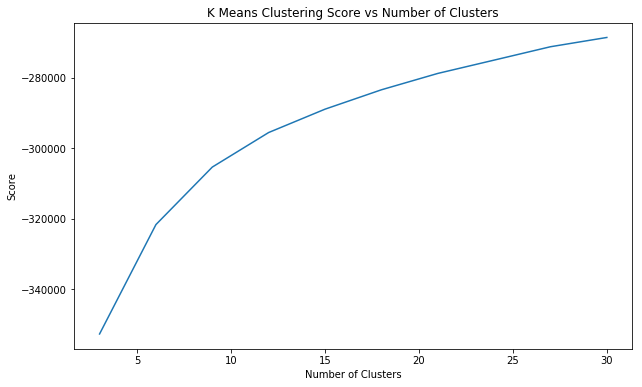

In [89]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.figure(figsize=(10, 6))
ax = plt.subplot(111)
plt.plot(clusterNumbers, scores)
ax.set_xlabel("Number of Clusters")
ax.set_ylabel("Score")
plt.title('K Means Clustering Score vs Number of Clusters')
plt.show()

Although there is no clear "elbow", a model with 10 to 15 clusters seem to balance the computatinoal cost to the accuracy. I will proceed with the 15 cluster model.

In [90]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans = KMeans(n_clusters=15, random_state=randomState).fit(df_reduced_scaled)

In [91]:
clusterLabels = kmeans.labels_

### Discussion 3.1: Apply Clustering to General Population

Although there is no clearly definable "elbow" in the graph above, a model with 10 to 15 clusters seem to score reasonably high, while minimizing the computational cost. I will proceed with the 15 cluster model.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [96]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [97]:
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,2,0,4.0,1,1,20.0,5.0,2.0,2.0,10.0,5.0,1,4,5.0,6,5,2,6,6,7,3,4,1,3,1,1,2,1,3,0.0,0.0,1,3,10.0,2.0,0.0,1.0,NaN,6.0,9.0,1.0,0.0,1.0,5.0,1992.0,W,7.0,1,1A,13,2.0,2.0,0.0,0.0,0.0,4.0,3.0,2.0,4.0,4.0,1.0,4.0,3.0,1.0,1201.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,2,0,NaN,0,1,NaN,NaN,NaN,NaN,NaN,NaN,1,0,NaN,3,6,2,6,7,5,3,4,1,3,3,2,4,1,3,0.0,0.0,1,3,11.0,3.0,0.0,NaN,NaN,0.0,9.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,2,0,3.0,1,2,13.0,3.0,1.0,1.0,10.0,5.0,1,4,5.0,2,2,1,3,3,7,7,1,2,7,5,6,4,1,1,0.0,0.0,2,3,6.0,1.0,0.0,1.0,NaN,6.0,9.0,1.0,0.0,8.0,1.0,1992.0,W,2.0,5,5D,34,2.0,2.0,0.0,0.0,0.0,3.0,7.0,4.0,1.0,3.0,3.0,3.0,1.0,7.0,433.0,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,6,0,10.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,1,3.0,6,5,3,4,7,5,3,4,3,3,3,3,3,4,0,0.0,0.0,1,1,8.0,0.0,0.0,4.0,NaN,NaN,9.0,0.0,NaN,2.0,2.0,1992.0,W,7.0,4,4C,24,3.0,0.0,0.0,0.0,1.0,4.0,7.0,1.0,7.0,4.0,3.0,4.0,2.0,6.0,755.0,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,2,1960,2.0,0,3,31.0,10.0,10.0,5.0,1.0,1.0,1,8,5.0,4,5,4,6,5,6,4,5,5,3,5,2,5,4,1,0.0,0.0,2,1,20.0,4.0,0.0,6.0,2.0,2.0,9.0,7.0,0.0,3.0,1.0,1992.0,W,3.0,7,7B,41,0.0,3.0,2.0,0.0,0.0,3.0,3.0,4.0,4.0,3.0,4.0,3.0,5.0,7.0,513.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [114]:
customersNanCounts = customers.isnull().sum(axis=1)

In [116]:
customers['nanCount'] = customersNanCounts

In [119]:
customers.shape

(191652, 75)

In [117]:
df_customers_missing = customers.loc[customers['nanCount'] > 30].copy()

In [118]:
df_customers_missing

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_FAMILIE_FEIN,LP_STATUS_FEIN,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,nanCount
1,4.0,1,NaN,5,1,5,1,3,2,2,NaN,0,1.0,NaN,NaN,NaN,1.0,NaN,NaN,3,6,2,6,7,5,3,4,1,3,3,2,4,1,3.0,0.0,1.0,3,3.0,0.0,NaN,NaN,9.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40
10,3.0,2,5.0,4,2,4,4,3,1,6,11.0,0,2.0,5.0,1.0,1.0,1.0,8.0,4.0,4,1,1,2,4,4,6,1,4,7,6,7,4,3,3.0,0.0,1.0,3,1.0,0.0,NaN,NaN,3.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32
36,1.0,2,6.0,3,4,3,5,5,3,4,5.0,0,NaN,NaN,NaN,5.0,NaN,NaN,3.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,3,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43
37,3.0,2,6.0,3,4,3,5,5,3,4,5.0,0,NaN,NaN,NaN,5.0,NaN,NaN,3.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,3,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43
38,2.0,2,6.0,3,4,3,5,5,3,4,5.0,0,NaN,NaN,NaN,5.0,NaN,NaN,3.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,3,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191467,1.0,1,6.0,3,4,3,5,5,3,4,5.0,0,NaN,NaN,NaN,5.0,NaN,NaN,3.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,3,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43
191477,1.0,1,6.0,3,4,3,5,5,3,4,4.0,0,NaN,38.0,10.0,9.0,NaN,NaN,3.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,3,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41
191481,2.0,2,6.0,3,4,3,5,5,3,4,5.0,0,NaN,NaN,NaN,5.0,NaN,NaN,3.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,3,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43
191553,3.0,2,3.0,4,3,4,4,3,1,3,4.0,0,2.0,5.0,1.0,1.0,1.0,NaN,5.0,4,1,1,2,4,4,6,1,4,7,6,7,4,3,3.0,0.0,1.0,6,1.0,0.0,NaN,NaN,9.0,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33


In [ ]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
df_customers = clean_data(customers)
imputedData = imputer.transform(df_customers)
df_customers_imputed = pd.DataFrame(imputedData, index=df_customers.index, columns=df_customers.columns)
df_customers_reduced = pca.transform(df_customers_imputed)

In [99]:
# Clustering the customers based on the 15 clusters
predictions = kmeans.predict(df_customers_reduced)

In [100]:
predictions # results of the customers cluster labels

array([8, 1, 1, ..., 1, 1, 8], dtype=int32)

In [101]:
clusterLabels # results of the cluster labels of the general population

array([ 7,  8, 11, ...,  7,  2,  6], dtype=int32)

In [102]:
# Counting the numbers in each clusters for the customers dataset
customersUnique, customersCounts = np.unique(predictions, return_counts=True)

In [103]:
customersCounts

array([77750,   448,   133, 43961])

In [104]:
customersUnique

array([1, 4, 5, 8], dtype=int32)

In [105]:
# Counting the numbers in each clusters for the general population dataset
generalUnique, generalCounts = np.unique(clusterLabels, return_counts=True)

In [106]:
generalUnique

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14], dtype=int32)

In [107]:
generalCounts

array([43870, 37247, 55546, 45802, 41384, 49914, 49280, 58890, 31514,
       48585, 36703, 47157, 41733, 31871, 50218])

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [112]:
generalTotal = len(clusterLabels) + df_missing.shape[0] # Adding the number of observation for the excluded observations (in section 1.1.3) back 

762657

In [153]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
generalTotal = len(clusterLabels) + df_missing.shape[0]
generalCountsPercent = []
for i in range(len(generalCounts)):

    generalCountsPercent.append(float(generalCounts[i]/generalTotal) * 100.0)

generalCountsPercent.append(float(df_missing.shape[0]/generalTotal) * 100.0) # Adding the percent of the counts for "missing many data" cluster

    
customersTotal = len(predictions)
customersCountsPercent = []
found = False
for i in range(15):
    found = False
    for ii in range(len(customersCounts)):
        if generalUnique[i] == customersUnique[ii]:
            customersCountsPercent.append(float(customersCounts[ii]/customersTotal) * 100.0)
            found = True
    if found == False:
        customersCountsPercent.append(0.0)
customersCountsPercent.append(0.0) # For the "missing many data" cluster percentage


In [134]:
generalUnique = np.append(generalUnique, 15) # Adding the "missing many data" cluster class

In [135]:
len(generalUnique)

16

In [136]:
df_general = pd.DataFrame(columns=['Cluster', 'PercentOfSample'])
df_customers = pd.DataFrame(columns=['Cluster', 'PercentOfSample'])

df_general['Cluster'] = generalUnique
df_general['PercentOfSample'] = generalCountsPercent

df_customers['Cluster'] = generalUnique
df_customers['PercentOfSample'] = customersCountsPercent

In [140]:
generalCountsPercent

[5.7522582235526585,
 4.883846866940185,
 7.283221684190927,
 6.00558311272302,
 5.42629255353324,
 6.544750785739854,
 6.461620361446889,
 7.721688780146252,
 4.132132793641178,
 6.370491584027945,
 4.812517291521615,
 6.183251448554199,
 5.472053623057286,
 4.178942827509615,
 6.584611430826702,
 12.186736632588438]

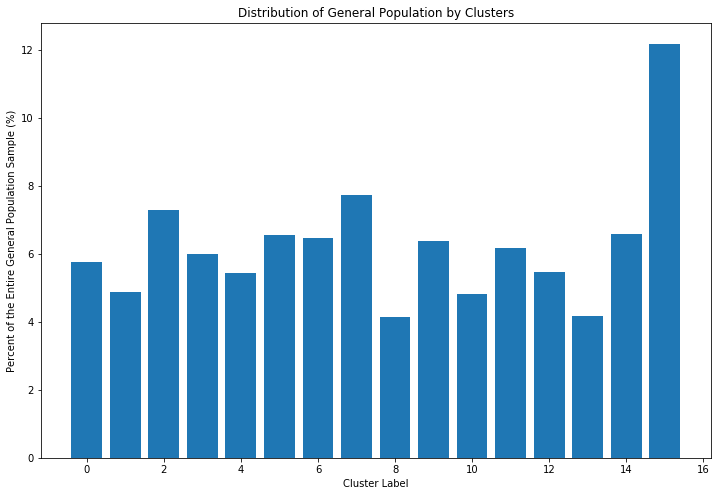

In [139]:
# Sample distribution plot of the general population dataset
fig, ax = plt.subplots()
plt.rcParams['figure.figsize'] = [12,8]
ax.bar(x=generalUnique, height=generalCountsPercent)
ax.set_title('Distribution of General Population by Clusters')
ax.set_xlabel('Cluster Label')
ax.set_ylabel('Percent of the Entire General Population Sample (%)')
plt.show()

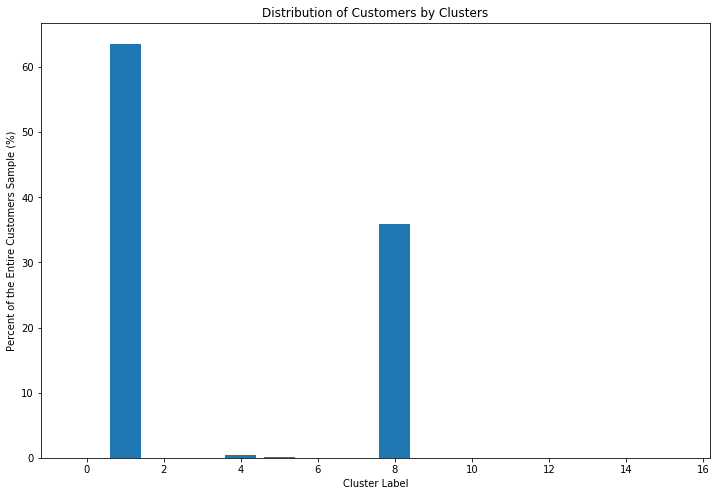

In [143]:
fig, ax = plt.subplots()
plt.rcParams['figure.figsize'] = [12,8]
ax.bar(x=generalUnique, height=customersCountsPercent)
ax.set_title('Distribution of Customers by Clusters')
ax.set_xlabel('Cluster Label')
ax.set_ylabel('Percent of the Entire Customers Sample (%)')
plt.show()

The majority of the customers belong to either Cluster 7 or 9. 

In [144]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# Getting the indices of observations that belong to the Cluster 1
generalCluster1Indices = np.where(clusterLabels == 1)[0]
generalCluster1Indices

array([    25,     26,     41, ..., 669646, 669649, 669669])

In [145]:
# Getting the indices of observations that belong to the Cluster 8
generalCluster8Indices = np.where(clusterLabels == 8)[0]
generalCluster8Indices

array([     1,      7,     22, ..., 669678, 669687, 669709])

In [146]:
# Getting the indices of observations that belong to the Cluster 0
generalCluster0Indices = np.where(clusterLabels == 0)[0]
generalCluster0Indices

array([    13,     40,     68, ..., 669647, 669677, 669701])

In [147]:
# Selecting the observations that belong to the cluster 1
df_cluster1 = df_complete.iloc[list(generalCluster1Indices), :].copy()

In [148]:
# Selecting the observations that belong to the cluster 8
df_cluster8 = df_complete.iloc[list(generalCluster8Indices), :].copy()

In [149]:
# Selecting the observations that belong to the cluster 0
df_cluster0 = df_complete.iloc[list(generalCluster0Indices), :].copy()

In [150]:
df_cluster1['FINANZTYP_6'].value_counts()

1    29349
0     7898
Name: FINANZTYP_6, dtype: int64

In [151]:
df_cluster8['FINANZTYP_6'].value_counts()

0    18081
1    13433
Name: FINANZTYP_6, dtype: int64

In [152]:
df_cluster0['FINANZTYP_6'].value_counts()

1    33761
0    10109
Name: FINANZTYP_6, dtype: int64

Clusters 12 and 10 are overrepresented; in fact, they are the target of the mail-order catalogue business. Some features stand out as being characteristics of these clusters. For example, people in this clusters are not likely to be financially minimalistic (FINANZ_MINIMALIST is typed as 4 [low tendenty]), financially inconspicuous (FINANZTYP is 6 [UNAUFFAELLINGER]), and thier dominating movement is mainstream (PRAEGENDE_JUGENDJAHR is of type mainstream), and they are not low-income earners (LP_STATUS_FEIN is not 1 [low-income earners]).

In [ ]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?


All clusters that are not targeted are underrepresented. As an example, people in cluster 0 are very likely to be money savers (FINANZ_SPARER is type 1 or 2 [very high or high, respectively]), financially not inconspicuous, not a house owner (LP_STATUS_FEIN type 9 is no), not a member of the Green Avantgarde movement (GREEN_AVANTGARDE type is 0 [not a member]), having the dominating mainstream movement.

### Discussion 3.3: Compare Customer Data to Demographics Data

As described above, there seems to be a clear distinction of the mail-order business customers; they are financially stable and from a mainstream movement. See above for more details.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.